In [1]:
import os, logging

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow_hub").setLevel(logging.CRITICAL)

import numpy as np
from skimage.draw import line
import tensorflow as tf
from PIL import Image
from matplotlib.pyplot import imshow
from IPython.display import display,  HTML
%matplotlib inline

In [2]:
def get_lined_images(image_width, num_samples):
    data_shape = (num_samples, image_width, image_width)

    data = np.zeros(data_shape, dtype=np.float32)
    targets = np.zeros((num_samples, 6), dtype=np.float32)
    
    epsilon = 1e-8
    rint = lambda: np.random.randint(0, image_width)

    for i in range(num_samples):
        x1, x2, y1, y2 = rint(), rint(), rint(), rint()
        rr, cc = line(x1, y1, x2, y2)
        data[i][rr, cc] = 1
        length = np.sum(data[i]) / image_width
        angle = np.arctan(abs(y1 - y2) / (abs(x1 - x2) + epsilon)) / np.pi
        targets[i][0:4] = [x1 / image_width, x2 / image_width, y1 / image_width, y2 / image_width]
        targets[i][4] = length
        targets[i][5] = angle
        
    data = np.expand_dims(data, axis=-1)
    return data, targets

In [3]:
def create_model(num_outputs):
    xin = tf.keras.layers.Input(shape=(None, None, 1))
    xconv = tf.keras.layers.Conv2D(2*num_outputs, 3, activation='relu', name="activation")(xin)
    xpool = tf.keras.layers.GlobalMaxPooling2D(name="pool")(xconv)
    xouts = tf.keras.layers.Dense(num_outputs, activation='relu', name="out")(xpool)
    model = tf.keras.Model(xin, outputs=xouts)
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    return model 

In [4]:
image_width = 128
num_samples = 100000

data, targets = get_lined_images(image_width, num_samples)
targets = targets[:,4:]
test_data, test_targets = get_lined_images(image_width, 10)

print (data.shape, targets.shape)

(100000, 128, 128, 1) (100000, 2)


In [5]:
model = create_model(targets.shape[-1])
model.summary()

model.fit(data, targets, batch_size=16, epochs=30, validation_split=0.2, shuffle=True)

outputs = model.predict(test_data)
print (outputs)
print (test_targets)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
activation (Conv2D)          (None, None, None, 4)     40        
_________________________________________________________________
pool (GlobalMaxPooling2D)    (None, 4)                 0         
_________________________________________________________________
out (Dense)                  (None, 2)                 10        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
Train on 80000 samples, validate on 20000 samples
Epoch 1/30
80000/80000 [==============================] - 13s 164us/sample - loss: 0.0271 - mean_squared_error: 0.0271 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 2/30
80000/80000 [==================

In [20]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

def array_as_img(array):
    array = np.asarray(array * 255, dtype=np.uint8)
    return Image.fromarray(array)

In [23]:
random_lines , _  = get_lined_images(256, 1)
activation_mdl = tf.keras.Model(model.layers[0].input, outputs=model.layers[1].output)
activation = activation_mdl.predict(random_lines[0:1])

activation_imgs = [array_as_img(activation[0,:,:,i]) for i in range(activation.shape[-1])]
data_img = array_as_img(random_lines[0,:,:,0])

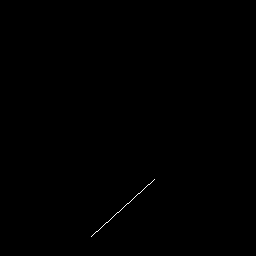

In [24]:
display(data_img)

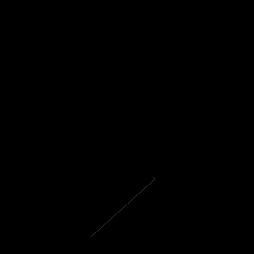

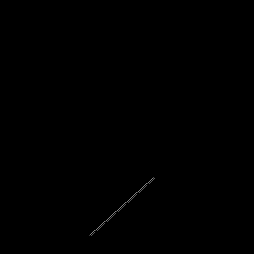

In [25]:
display(*activation_imgs)